In [52]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import NAdam
from torch.optim import SGD
from torch.autograd import Variable
import torchvision
import pathlib

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [7]:
train_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\train'
test_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=128, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=64, shuffle=True
)

In [8]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['benign', 'malignant']


In [17]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=5,stride=1,padding=2)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ELU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=5,stride=1,padding=2)
        #Shape= (256,20,75,75)
        self.relu2=nn.ELU()
        #Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=5,stride=1,padding=2)
        #Shape= (256,20,75,75)
        self.relu3=nn.ELU()
        #Shape= (256,20,75,75)
        
        self.conv4=nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,stride=1,padding=2)
        #Shape= (256,32,75,75)
        self.bn4=nn.BatchNorm2d(num_features=48)
        #Shape= (256,32,75,75)
        self.relu4=nn.ELU()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 48,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
        
        output=self.conv3(output)
        output=self.relu3(output)
        
        output=self.conv4(output)
        output=self.bn4(output)
        output=self.relu4(output)
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,48*75*75)
        output=self.fc(output)            
        return output

In [18]:
model=ConvNet(num_classes=2).to(device)

In [19]:
optimizer=NAdam(model.parameters(),lr=0.0001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [36]:
num_epochs=100

In [37]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [38]:
ta = [0]*100
tl = [0]*100
tea = [0]*100
tel = [0]*100

In [20]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss = 0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        test_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss= test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_elu.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(1.1897) Train Accuracy: 0.7364429275692075 Test Accuracy: 0.693939393939394
Epoch: 1 Train Loss: tensor(3.3383) Train Accuracy: 0.7447857413727721 Test Accuracy: 0.703030303030303
Epoch: 2 Train Loss: tensor(2.1802) Train Accuracy: 0.7834660599165718 Test Accuracy: 0.7666666666666667
Epoch: 3 Train Loss: tensor(1.6486) Train Accuracy: 0.80128934395146 Test Accuracy: 0.8090909090909091
Epoch: 4 Train Loss: tensor(1.7566) Train Accuracy: 0.7880166856276072 Test Accuracy: 0.8333333333333334
Epoch: 5 Train Loss: tensor(1.5295) Train Accuracy: 0.7846037163443307 Test Accuracy: 0.8227272727272728
Epoch: 6 Train Loss: tensor(1.3023) Train Accuracy: 0.8153204398938187 Test Accuracy: 0.8424242424242424
Epoch: 7 Train Loss: tensor(2.0523) Train Accuracy: 0.7849829351535836 Test Accuracy: 0.7606060606060606
Epoch: 8 Train Loss: tensor(4.3075) Train Accuracy: 0.7713310580204779 Test Accuracy: 0.8166666666666667
Epoch: 9 Train Loss: tensor(2.6369) Train Accuracy: 0.78536

Epoch: 81 Train Loss: tensor(0.1034) Train Accuracy: 0.9768676526355707 Test Accuracy: 0.9939393939393939
Epoch: 82 Train Loss: tensor(0.1067) Train Accuracy: 0.9738339021615472 Test Accuracy: 0.9878787878787879
Epoch: 83 Train Loss: tensor(0.1628) Train Accuracy: 0.9651118695487296 Test Accuracy: 0.9924242424242424
Epoch: 84 Train Loss: tensor(0.0879) Train Accuracy: 0.9719378081152825 Test Accuracy: 0.9924242424242424
Epoch: 85 Train Loss: tensor(0.1198) Train Accuracy: 0.9711793704967766 Test Accuracy: 0.9984848484848485
Epoch: 86 Train Loss: tensor(0.1459) Train Accuracy: 0.9677664012135002 Test Accuracy: 0.9803030303030303
Epoch: 87 Train Loss: tensor(0.1933) Train Accuracy: 0.9544937428896473 Test Accuracy: 0.9651515151515152
Epoch: 88 Train Loss: tensor(0.1917) Train Accuracy: 0.9594235874099355 Test Accuracy: 0.8772727272727273
Epoch: 89 Train Loss: tensor(5.5105) Train Accuracy: 0.782707622298066 Test Accuracy: 0.793939393939394
Epoch: 90 Train Loss: tensor(5.4580) Train Accur

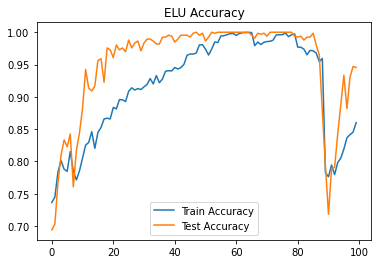

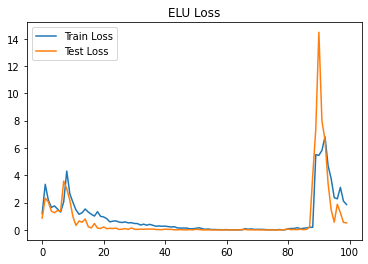

In [21]:
# 5x5 kernel, 4 layers, 48 channel
plt.title('ELU Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('ELU Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [20]:
import torchinfo

In [21]:
torchinfo.summary(model, (3, 150, 150), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 
                                                                    'kernel_size', 'mult_adds'), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ConvNet                                  [1, 3, 150, 150]          [1, 2]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 150, 150]          [1, 12, 150, 150]         336                       [3, 3]                    7,560,000
├─BatchNorm2d: 1-2                       [1, 12, 150, 150]         [1, 12, 150, 150]         24                        --                        24
├─ELU: 1-3                               [1, 12, 150, 150]         [1, 12, 150, 150]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 12, 150, 150]         [1, 12, 75, 75]           --                        2                         --
├─Conv2d: 1-5                            [1, 12, 75, 75]           [1, 20, 75, 75]           2,180

In [22]:
a = [0]*100
l = [0]*100
for i in range(0,100):
    a[i] = ta[i] - tea[i]
    l[i] = tel[i] - tl[i]
sa=0
sl=0
for i in range(0,100):
    sa = sa + a[i]
    sl = sl + l[i]

In [23]:
sa1=0
sa2=0
sl1=0
sl2 = 0
for i in range(0,100):
    sa1 = sa1+ta[i]
    sl1 = sl1+tl[i]
    sa2 = sa2+tea[i]
    sl2 = sl2+tel[i]

In [24]:
#Avg Difference in Accuracy
print(sa/100)

-0.0353315406625987


In [25]:
#Avg Difference in Loss
sl/100

tensor(-0.1678)

In [26]:
#Avg Train Accuracy
sa1

91.49108835798255

In [27]:
#Avg Test Accuracy
sa2

95.02424242424249

In [31]:
#Avg Train Loss
sl1/100

tensor(0.9298)

In [32]:
#Avg Test Loss
sl2/100

tensor(0.7620)

In [59]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=5,stride=1,padding=2)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ELU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=5,stride=1,padding=2)
        #Shape= (256,20,75,75)
        self.relu2=nn.ELU()
        #Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=5,stride=1,padding=2)
        #Shape= (256,20,75,75)
        self.relu3=nn.ELU()
        #Shape= (256,20,75,75)
        
        self.conv4=nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,stride=1,padding=2)
        #Shape= (256,32,75,75)
        self.bn4=nn.BatchNorm2d(num_features=48)
        #Shape= (256,32,75,75)
        self.relu4=nn.ELU()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 48,out_features=num_classes)
        self.dropout=nn.Dropout(0.5)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
        
        output=self.conv3(output)
        output=self.relu3(output)
        
        output=self.conv4(output)
        output=self.bn4(output)
        output=self.relu4(output)
        
        output=self.dropout(output)
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,48*75*75)
        output=self.fc(output)            
        return output

In [60]:
model=ConvNet(num_classes=2).to(device)

In [61]:
optimizer=NAdam(model.parameters(),lr=0.0001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [62]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss = 0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        test_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss= test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_elu.pth')
        best_accuracy=test_accuracy

RuntimeError: CUDA out of memory. Tried to allocate 132.00 MiB (GPU 0; 4.00 GiB total capacity; 3.29 GiB already allocated; 0 bytes free; 3.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

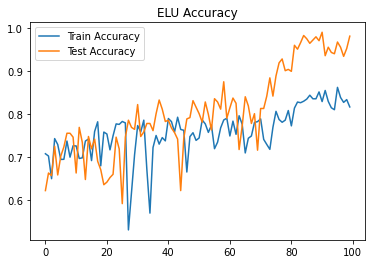

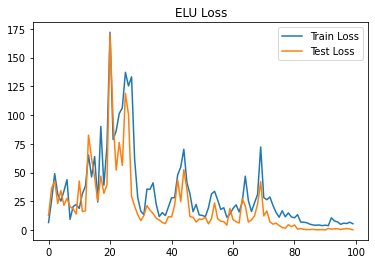

In [40]:
# 3x3 kernel, 3 layers, 48 channel
plt.title('ELU Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('ELU Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [41]:
a = [0]*100
l = [0]*100
for i in range(0,100):
    a[i] = ta[i] - tea[i]
    l[i] = tel[i] - tl[i]
sa=0
sl=0
for i in range(0,100):
    sa = sa + a[i]
    sl = sl + l[i]
sa1=0
sa2=0
sl1=0
sl2 = 0
for i in range(0,100):
    sa1 = sa1+ta[i]
    sl1 = sl1+tl[i]
    sa2 = sa2+tea[i]
    sl2 = sl2+tel[i]

In [48]:
sl1/100

tensor(31.7233)